In [1]:
from sklearn import svm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    return ax

In [2]:
def get_data(class_images):
    xs = np.empty((0, 3))
    ys = np.empty(0)
    for i in range(len(class_images)):
        img = Image.open(class_images[i])
        img_mat = np.asarray(img)
        i_x = img_mat.reshape(-1, img_mat.shape[-1])
        i_y = np.empty(len(i_x))
        i_y.fill(i)
        xs = np.append(xs, i_x, axis=0)
        ys = np.append(ys, i_y)
    return xs, ys

def overlay_pixel(color, alpha, pixel):
    color = color * alpha
    pixel = pixel * (1 - alpha)
    return np.array(pixel + color).astype('uint8')

def get_overlay(orig_img, colors, clf):
    img = Image.open(orig_img)
    img_mat = np.asarray(img)
    flat_img_mat = np.array(img_mat.reshape(-1, img_mat.shape[-1]))
    prediction_mat = clf.predict(flat_img_mat)
    overlayed = np.array([overlay_pixel(colors[pred], 0.3, pixel) for pred, pixel in zip(prediction_mat, flat_img_mat)])
    overlayed = overlayed.reshape(img_mat.shape)
    return overlayed

### Construir set de datos

In [3]:
VACA = 0
CIELO = 1
PASTO = 2

xs, ys = get_data(['data/vaca.jpg', 'data/cielo.jpg', 'data/pasto.jpg'])

x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.33, random_state=42)

## Linear kernel

### Entrenamiento

In [4]:
cow_linear_clf = svm.SVC(kernel = 'linear', C = 1)
cow_linear_clf.fit(x_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

### Predicción

In [5]:
test_pred = cow_linear_clf.predict(x_test)
test_true = y_test

### Métricas

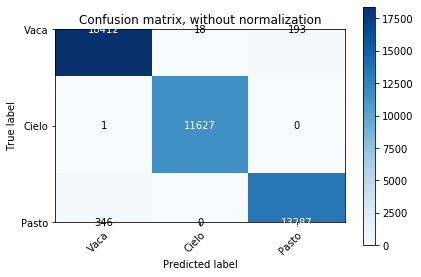

In [6]:
plot_confusion_matrix(test_true, test_pred, classes=['Vaca', 'Cielo', 'Pasto'])

## RBF Kernel

### Entrenamiento

In [7]:
cow_rbf_clf = svm.SVC(kernel = 'rbf', C = 1, gamma = 'scale')
cow_rbf_clf.fit(x_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Predicción

In [8]:
test_pred = cow_rbf_clf.predict(x_test)
test_true = y_test

### Métricas

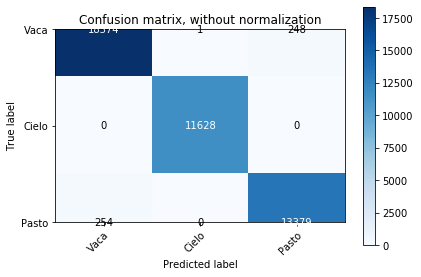

In [9]:
plot_confusion_matrix(test_true, test_pred, classes=['Vaca', 'Cielo', 'Pasto'])

## Polinomial Kernel

### Entrenamiento

In [10]:
cow_poly_clf = svm.SVC(kernel = 'poly', C = 1, gamma = 'scale')
cow_poly_clf.fit(x_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Predicción

In [11]:
test_pred = cow_poly_clf.predict(x_test)
test_true = y_test

### Métricas

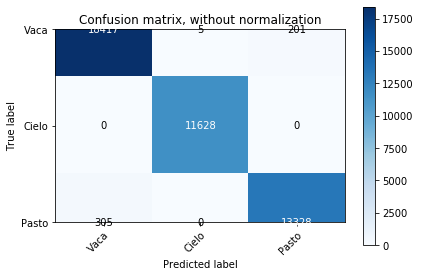

In [12]:
plot_confusion_matrix(test_true, test_pred, classes=['Vaca', 'Cielo', 'Pasto'])

## Overlay sobre la imagen original
Pinto una sombra de color sobre los píxeles de la imagen original para visualizar como los clasifica el SVM

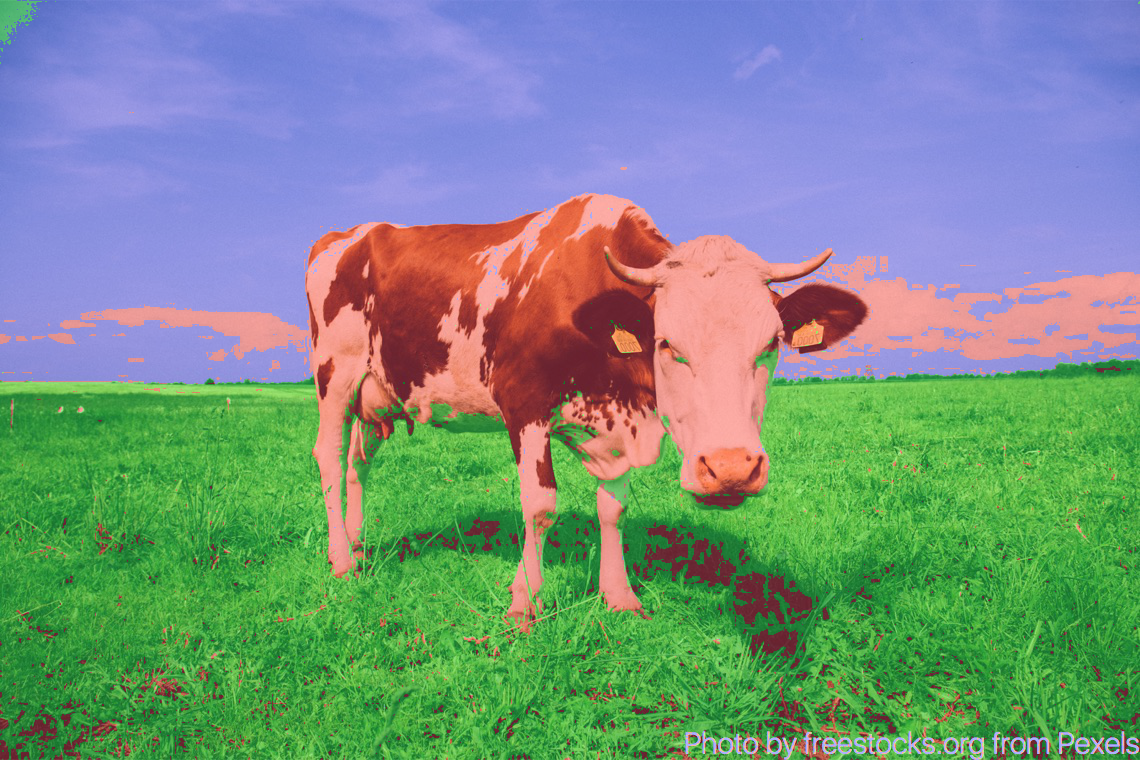

In [13]:
CLASS_COLORS = { 
    VACA: np.array([255, 0, 0]), # RED
    CIELO: np.array([0, 0, 255]), # BLUE
    PASTO: np.array([0, 255, 0])  # GREEN
}

over_mat = get_overlay('data/cow.jpg', CLASS_COLORS, cow_poly_clf)
Image.fromarray(over_mat)

## Overlay sobre otra imagen
Pinto una sombra de color sobre los píxeles de la imagen original para visualizar como los clasifica el SVM

In [14]:
GATO = 0
ALFOMBRA = 1
ZAPATILLA = 2

CLASS_COLORS = { 
    GATO: np.array([255, 0, 0]), # RED
    ALFOMBRA: np.array([0, 0, 255]), # BLUE
    ZAPATILLA: np.array([0, 255, 0])  # GREEN
}

xs, ys = get_data(['data/gato.jpg', 'data/alfombra.jpg', 'data/zapatilla.jpg'])

In [15]:
x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.33, random_state=42)

In [16]:
clf = svm.SVC(kernel = 'rbf', gamma = 'scale', C = 1)
clf.fit(x_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

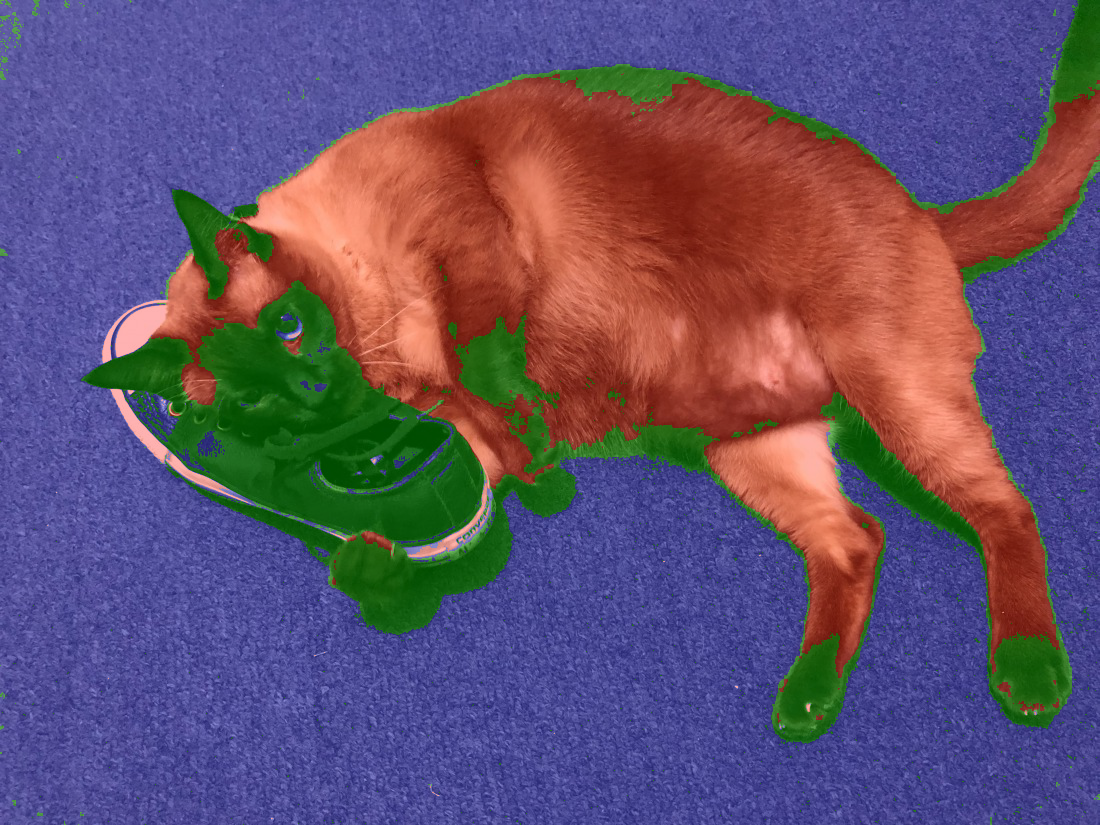

In [17]:
over_mat = get_overlay('data/steve.jpg', CLASS_COLORS, clf)
Image.fromarray(over_mat)